In [472]:
import pandas as pd
import os

path = "./forecasting_data-all/"
folder = os.listdir(path)

start_day = '2021-10-01'
end_day = '2022-03-22'

df = pd.DataFrame(index = pd.date_range(start=start_day, end=end_day,freq='10D'), columns = ["SOH"])

for f in folder:
    month = f"{f[:4]}-{f[4:6]}-{f[6:]}"
    if pd.to_datetime(month) in df.index:
        rack = pd.read_csv(path + f + "/rack.csv")
        rack = rack[rack["RACK_ID"] == 1]

        t = pd.to_datetime(f"{f[:4]}-{f[4:6]}-{f[6:]}")
        df.loc[t]["SOH"] = rack.iloc[-1]["RACK_SOH"]

df["SOH"] = (df["SOH"]-80) * 5
df.fillna(method='ffill', inplace = True) # 뒷 행을 기준으로 nan 채우기

#df.to_csv("day-to-soh.csv")

c:\users\juhyeong\desktop\rack_analysis\.venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


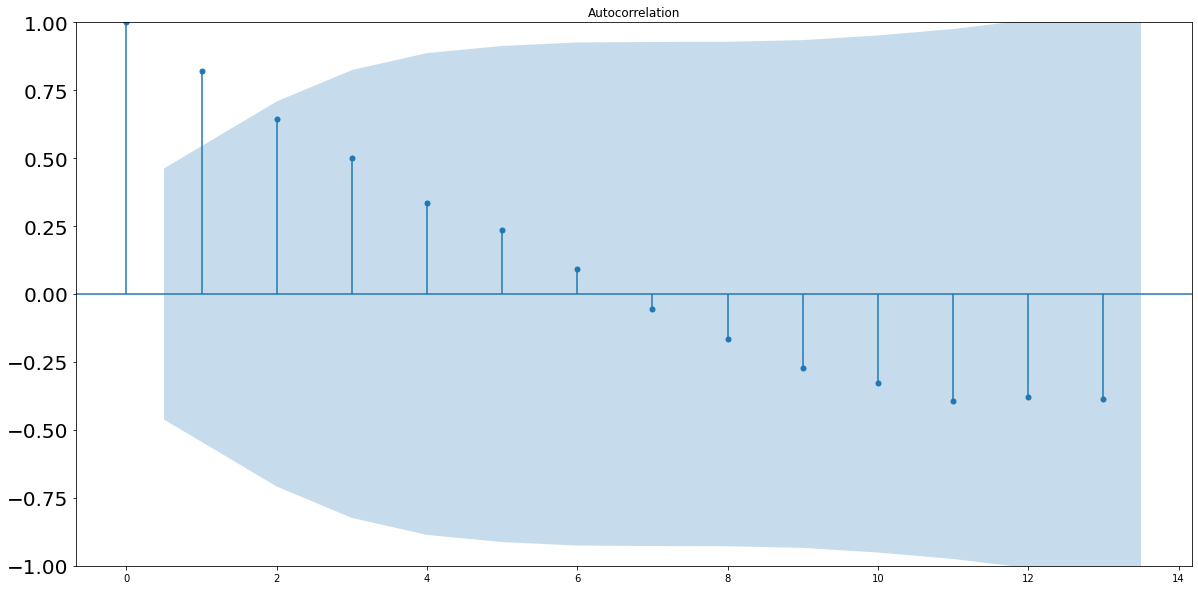

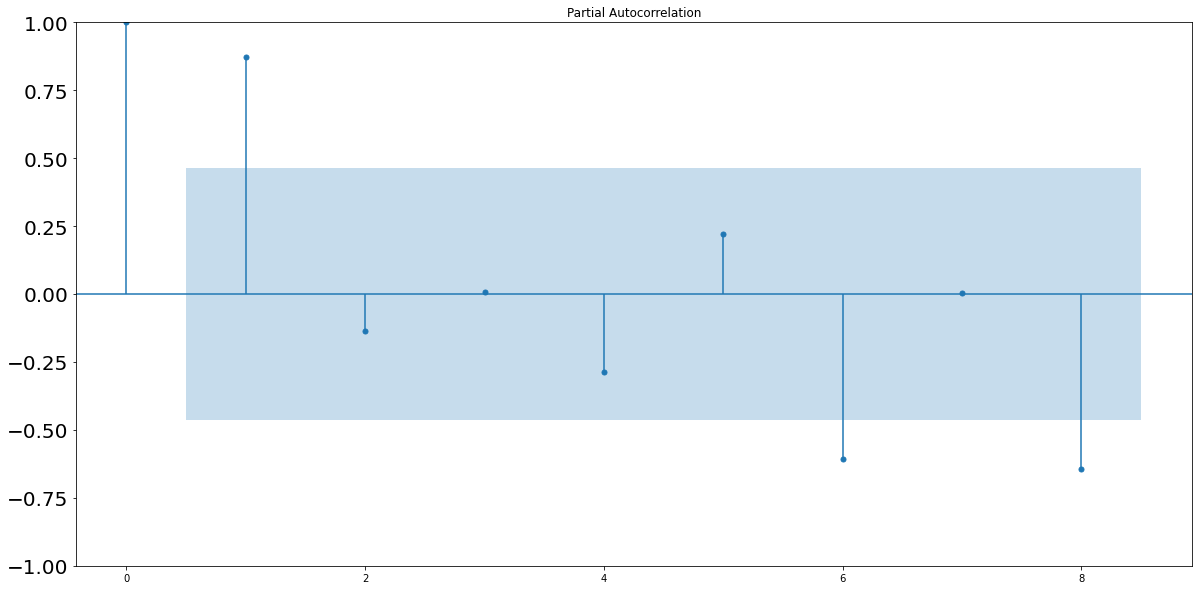

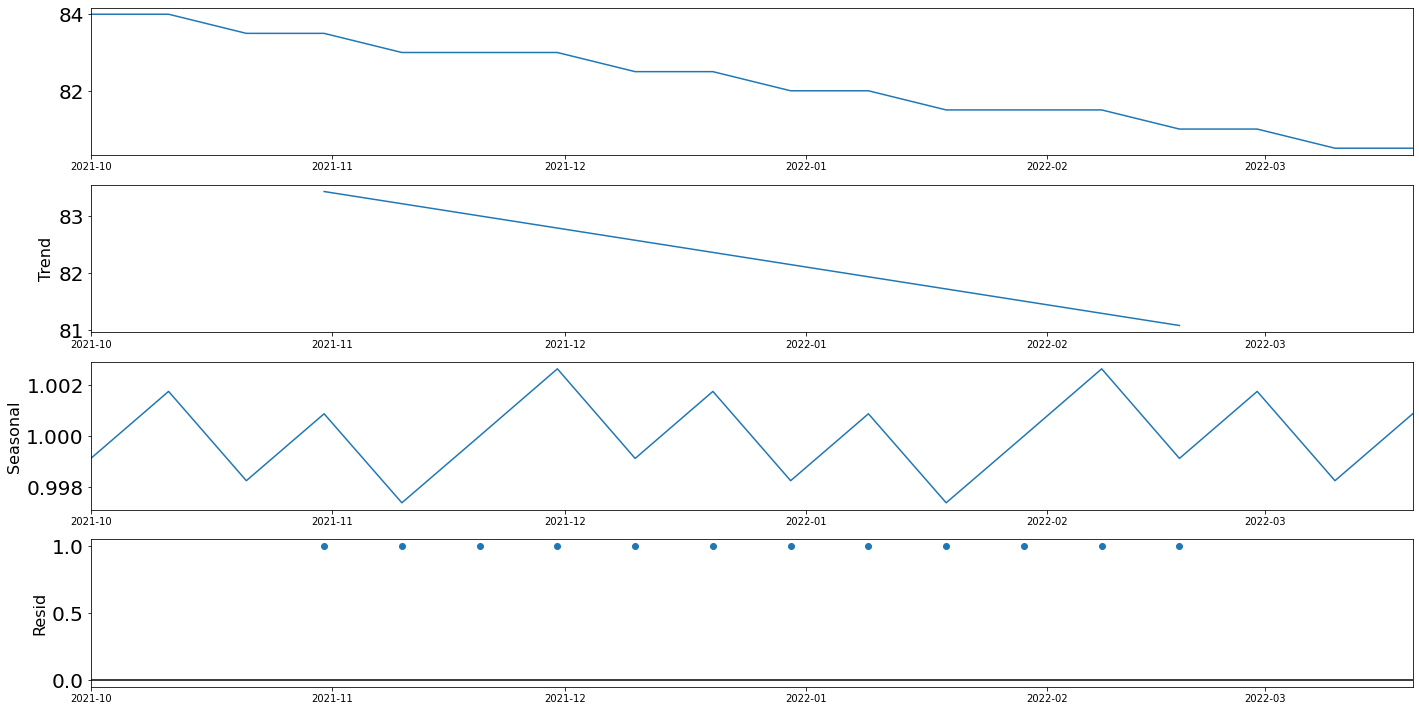

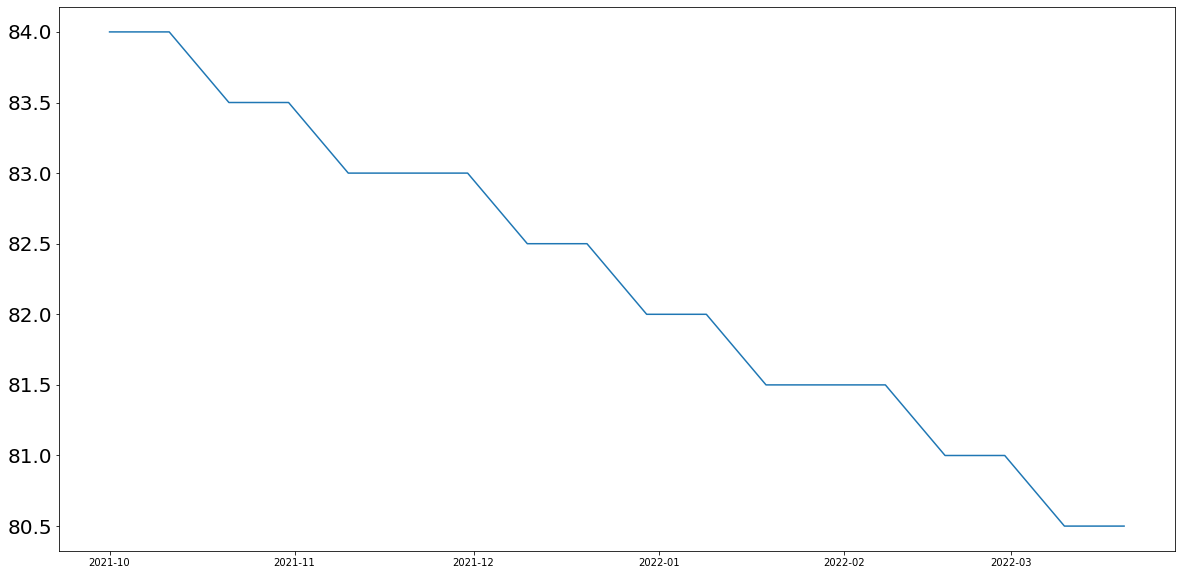

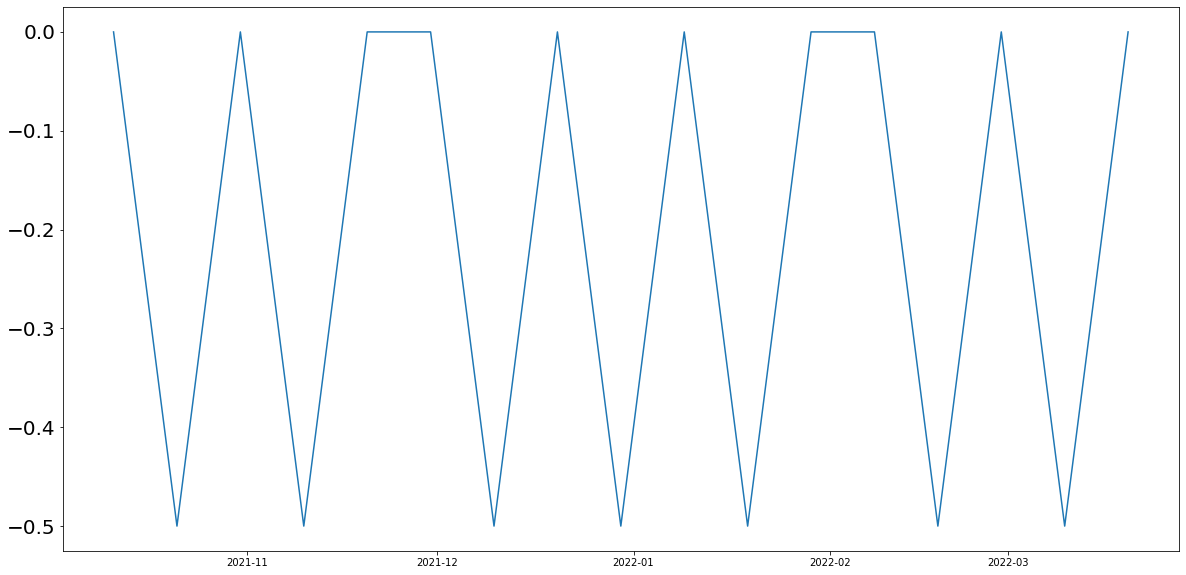

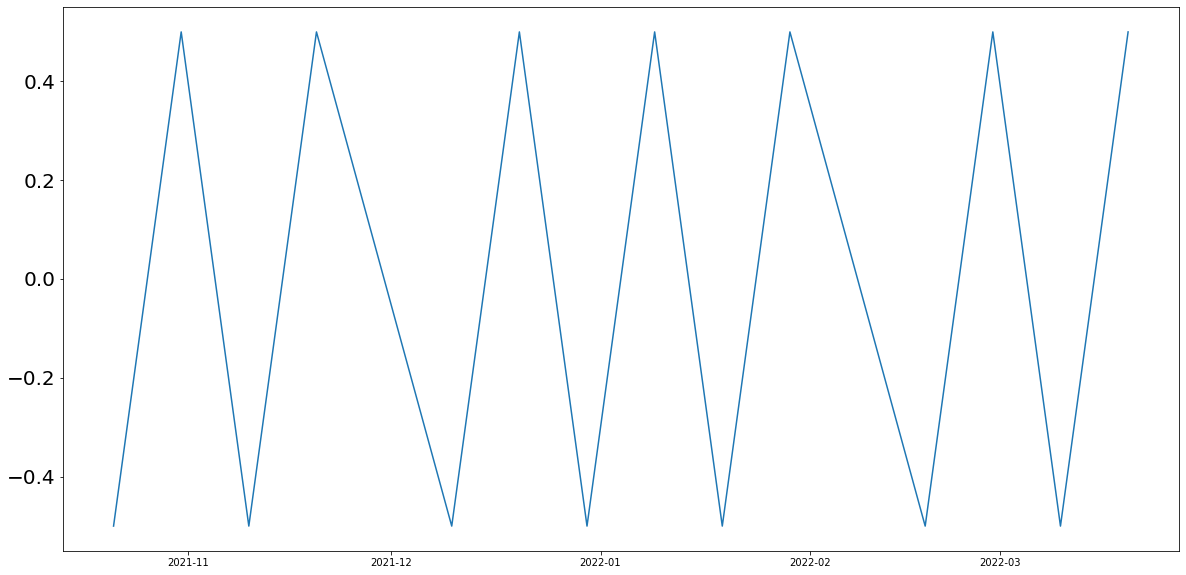

In [473]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

train_idx = (df.index >= start_day) & (df.index <= end_day)
train = df.loc[train_idx]

val_idx = (df.index >= "2022-03-01") & (df.index <= "2022-03-22")
validation = df.loc[val_idx]

plot_acf(train)
plot_pacf(train, lags=len(train)//2-1)

plt.show()

seasonal_decompose(train, model = 'multiplicative').plot()
plt.show()

plt.plot(train.index,train["SOH"])
plt.show()

diff_1 = train["SOH"].diff().dropna()
plt.plot(diff_1)

plt.show()

diff_2 = diff_1.diff().dropna()
plt.plot(diff_2)

plt.show()


In [506]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

import statsmodels.api as sm

# best : order = (1,1,1), seasonal_order = (3,1,2,6)
# best : order = (1,1,1), seasonal_order = (2,1,2,6) / AIC=-25.379
# second : order = (1,2,1), seasonal_order = (4,1,2,3)
# third : order = (2,1,1), seasonal_order = (4,1,2,3)
model = SARIMAX(train["SOH"], order = (1,2,1), seasonal_order = (4,1,2,3))
#model = ARIMA(train, order = (1,2,0), enforce_stationarity = False)
model_fit = model.fit()
print(model_fit.summary())

c:\users\juhyeong\desktop\rack_analysis\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                       SARIMAX Results                                        
Dep. Variable:                                    SOH   No. Observations:                   18
Model:             SARIMAX(1, 2, 1)x(4, 1, [1, 2], 3)   Log Likelihood                  12.929
Date:                                Tue, 29 Mar 2022   AIC                             -7.857
Time:                                        13:29:59   BIC                             -2.773
Sample:                                    10-01-2021   HQIC                            -8.902
                                         - 03-20-2022                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6418      0.026    -24.671      0.000      -0.693      -0.591
ma.

c:\users\juhyeong\desktop\rack_analysis\.venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


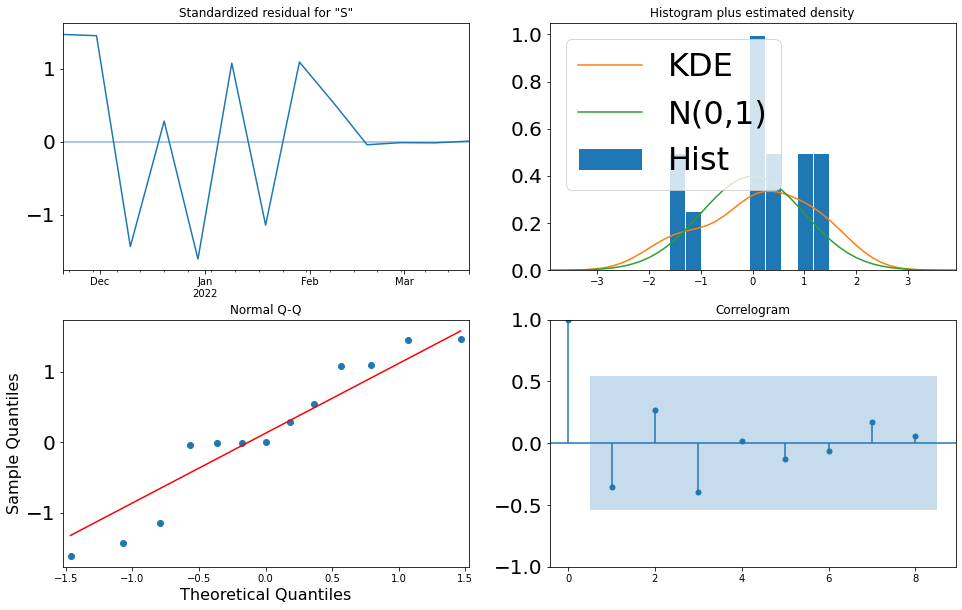

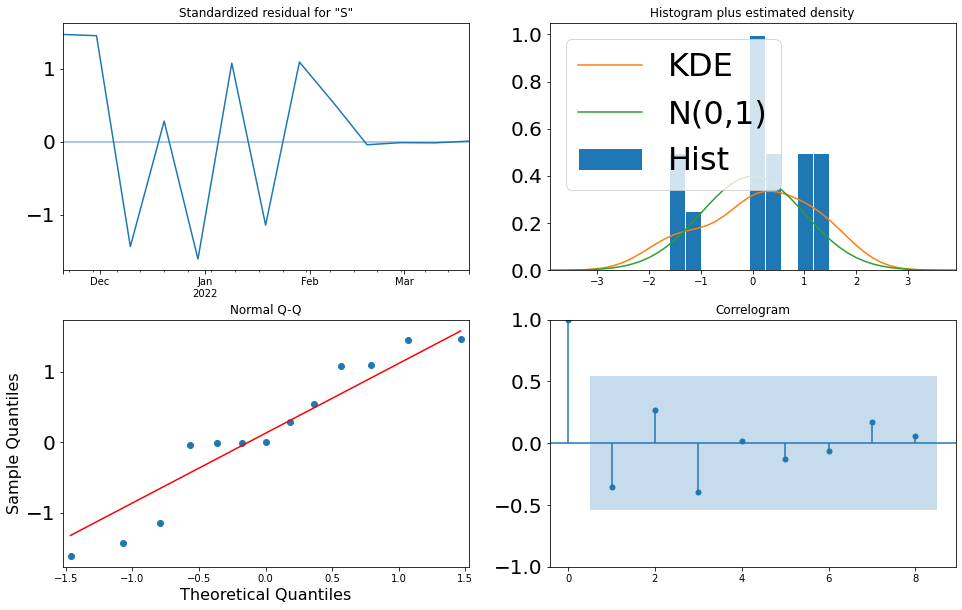

In [507]:
model_fit.plot_diagnostics(figsize=(16,10), lags=len(train)//2-1)

In [508]:
pred_start_day = '2022-03-20'
pred_end_day = '2035-12-30'

pred = model_fit.get_prediction(start=pd.to_datetime(pred_start_day),
                               end=pd.to_datetime(pred_end_day),
                               dynamic=True)

(0.0, 100.0)

<Figure size 1152x1152 with 0 Axes>

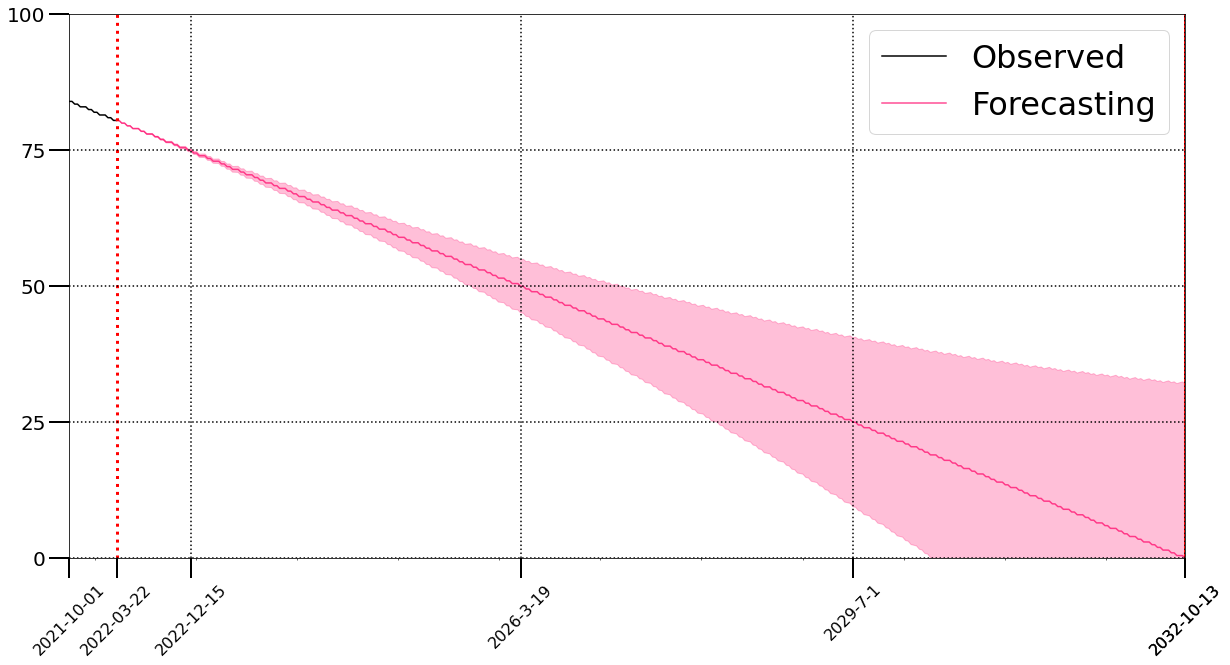

In [509]:
plt.figure(figsize=(16,16))
plt.rcParams['figure.figsize'] = [20, 10]
plt.rc('axes', titlesize=12, labelsize=16)
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=32)  # 범례 폰트 크기

def vhline_to_point(pm,v):
    for pidx, pv in zip(pm.index,pm.values):
        if pv <= v:
            ax.axvline(x=pidx, color='black', linestyle=':', ymin =0, ymax=1)
            break
    
    x = pidx
    ax.axhline(y=y, color='black', linestyle=':', xmin=0, xmax=1)
    return x

ax = train.plot(label='Observed', color="black", legend=True)
pred.predicted_mean.plot(ax=ax, label='Forecasting', alpha=0.7, color="#ff0066")

pred_ci = pred.conf_int()

#print(pred_ci)

ax.fill_between(pred_ci.index,
               pred_ci.iloc[:,0],
               pred_ci.iloc[:,1], color='#ff0066', alpha=0.25)

ax.axvline(x=end_day, color='r', linestyle=':', linewidth=3)

for pidx, pv in zip(pred.predicted_mean.index,pred.predicted_mean.values):
    if pv <= 0:
        ax.axvline(x=pidx, color='r', linewidth=3)
        break

zpoint = pidx
yy = [75,50,25,0]
xticks = []

for y in yy:
    t = vhline_to_point(pred.predicted_mean,y)
    xticks.append(f"{t.year}-{t.month}-{t.day}")

ax.set_xticks([start_day,end_day,pidx, pred_end_day] + xticks ,minor = False)
ax.set_xticklabels([start_day,end_day,f"{pidx.year}-{pidx.month}-{pidx.day}", pred_end_day] + xticks, rotation = 45, fontsize = 16)

ax.set_yticks([100,75,50,25,0])

ax.tick_params(length=20, width=2)
ax.legend(["Observed", "Forecasting"])

ax.set_xlim([start_day,pidx])
ax.set_ylim([0,100])

# 대략 2033년 8월 28일쯤에 0%로 변함